## CNN to classify Cat and Dog

# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions
* The objective is to train a CNN model able to predict if  image is a cat or a dog.

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [316]:
from plot_lib import plot_data, plot_model, set_default

In [317]:
set_default()

In [318]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from matplotlib.image import imread
import cv2
import os


# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# Load the Dataset (Dog_vs_cat)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [319]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


# define training,  and test data directories
data_dir = 'Cat_Dog_data/'
train_dir = os.path.join(data_dir, 'train/')
#valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(size=224),
                                     transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])



test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(train_dir, transform=train_transform)
#valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [250]:
#next(iter(train_loader))

### To check the label

In [320]:
print(train_data.class_to_idx)
print(test_data.class_to_idx)

{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}


This means the cat is labeled by 0 and dog by 1.

### Let's check the size of the input (images) and the label

In [321]:
torchimage =iter( train_loader) #create a iterator from a train_loader object
images, labels = torchimage.next() #builds tensors for the images and the lables in the batch
print(labels[0:]) # printt the label of the images in the batch
print(images.size()) #print the size of the batch

tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0])
torch.Size([20, 3, 224, 224])


In [322]:
labels[0]

tensor(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


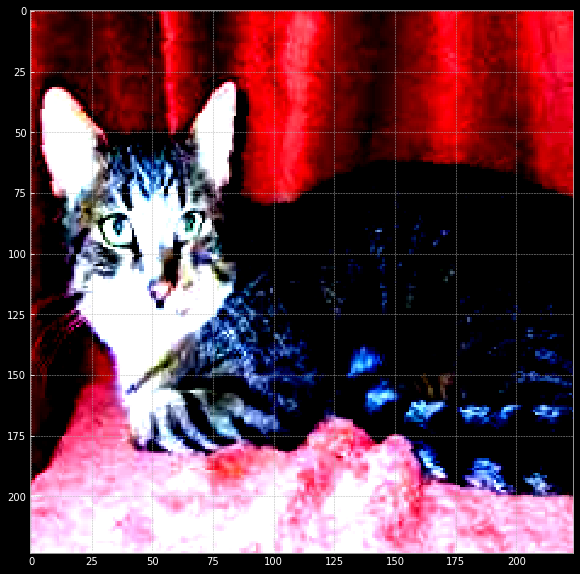

In [323]:
plt.imshow(train_loader.dataset.__getitem__(i)[0].squeeze().numpy().transpose(1,2,0))
# images.shape


In [307]:
train_loader.dataset.__getitem__(i)[1]

0

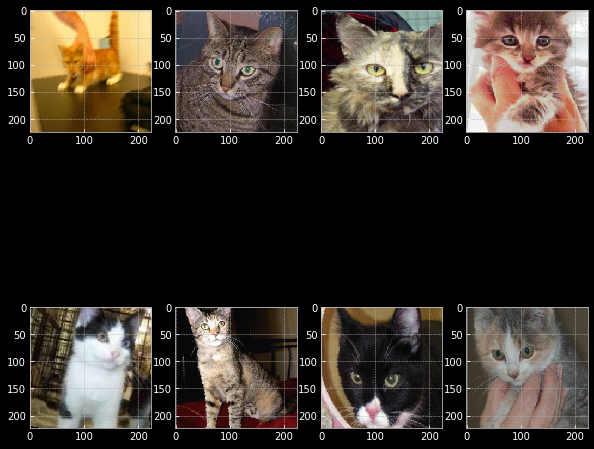

In [167]:
# show some images
plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0))

# Create the model classes

Defie the CNN model, it is a classification model with 2 outputs(cat or dog)

In [328]:
input_size  = 224*224*3   # images are 28x28 pixels
output_size = 2     # there are 10 classes

In [329]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        ) ##sequential = stack layers #The archicteture of the model

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*53*53, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*53*53) #(batch_size, -1) we can use also this
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### A function to check the outpout shape and the filter size

In [334]:

import torch.nn as nn
n_feature = 6
check_archi = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(n_feature, n_feature, kernel_size=5),
                            nn.MaxPool2d(2, 2))

In [335]:
# image.unsqueeze(0).shape
filt, size = check_archi(torch.rand(20,3, 224, 224)).shape[1],\
        check_archi(torch.rand(20,3, 224, 224)).shape[2]
print(f'filter size {filt} and output shape {size}')

filter size 6 and output shape 53


In [336]:
check_archi(torch.rand(1,3, 224, 224)).shape[2]

53

In [337]:
# y.forward(image.unsqueeze(0))

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [338]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Let's train our model

In [339]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 50176).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # permute pixels
#         data = data.view(-1, 3*224*224)
#         data = data[:, perm]
#         data = data.view(-1, 3, 224, 224)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 50176).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # permute pixels
        data = data.view(-1, 224*224)
        data = data[:, perm]
        data = data.view(-1, 3, 224, 224)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [340]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 1204322
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.668882
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.671535
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.597342
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.592186
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.649943
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.650261
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.724844
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.648833
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.617124
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.703370
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.701752
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.760497

Test set: Average loss: 0.6707, Accuracy: 1461/2500 (58%)



# Train a ConvNet with the same number of parameters

In [341]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 844214
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.672904
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.695177
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.646223
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.695235
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.640233
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.576733
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.680413
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.624784
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.701981
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.515474
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.641743
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.637963

Test set: Average loss: 0.6162, Accuracy: 1642/2500 (66%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance




## Using Transfer learning "VVGG16"

In [342]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
import torch.nn as nn

n_inputs = model_transfer.classifier[6].in_features

# # dd last linear layer (n_inputs -> 5 flower classes)
# # new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 2)

model_transfer.classifier[6] = last_layer

# # check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

# if use_cuda:
#     model_transfer = model_transfer.cuda()

2


In [343]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [399]:
# Training settings 
n_features = 6 # number of feature maps

optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_transfer, perm)
    test(model_transfer, perm)

Number of parameters: 844214
Train Epoch: 0 [0/22500 (0%)]	Loss: nan
Train Epoch: 0 [2000/22500 (9%)]	Loss: nan
Train Epoch: 0 [4000/22500 (18%)]	Loss: nan
Train Epoch: 0 [6000/22500 (27%)]	Loss: nan
Train Epoch: 0 [8000/22500 (36%)]	Loss: nan
Train Epoch: 0 [10000/22500 (44%)]	Loss: nan
Train Epoch: 0 [12000/22500 (53%)]	Loss: nan
Train Epoch: 0 [14000/22500 (62%)]	Loss: nan
Train Epoch: 0 [16000/22500 (71%)]	Loss: nan
Train Epoch: 0 [18000/22500 (80%)]	Loss: nan
Train Epoch: 0 [20000/22500 (89%)]	Loss: nan
Train Epoch: 0 [22000/22500 (98%)]	Loss: nan

Test set: Average loss: nan, Accuracy: 1250/2500 (50%)



### The transfer learning is not working for now. We'll perform in the next Notebook!

## Using permutation in the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

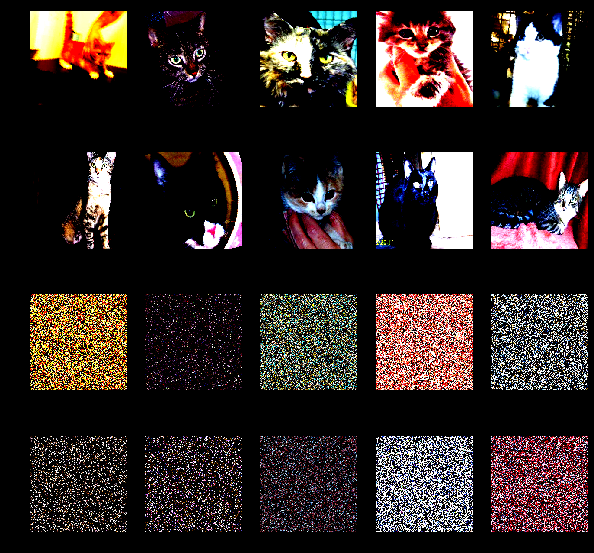

In [344]:
perm = torch.randperm(50176)
plt.figure()
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 224*224).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 3, 224, 224)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0))
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy().transpose(1,2,0))
    plt.axis('off')

# ConvNet with permuted pixels

In [347]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 844214
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.697512
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.678948
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.700901
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.670460
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.670696
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.623261
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.588021
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.616852
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.655246
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.661201
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.499240
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.517881

Test set: Average loss: 0.7261, Accuracy: 1287/2500 (51%)



# Fully-Connected with Permuted Pixels

In [348]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 1204322
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.733842
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.704271
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.733990
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.704770
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.693857
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.689368
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.745807
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.631259
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.698163
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.685988
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.705348
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.618917

Test set: Average loss: 0.6886, Accuracy: 1318/2500 (53%)




## (IMPLEMENTATION) Predict Dog or Cat with our Model

Below, we write a function that takes an image path as input and predict  if it is a  dog or cat. 
Don't forget that our target has 2 classes, 0: the cat and  1: Dog


In [369]:
#Import the image
path = 'Cat_Dog_data/Im2.jpg'
data_transfer = {'train' : train_data, 'test' :test_data}

In [380]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image


def predict_transfer(img_path):
    # load the image and return the predict
    
    data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    img = data_transform(Image.open(img_path))
#     if use_cuda:
#         img = img.cuda()
        
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
    
    img = img.unsqueeze(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims. 
    
    prediction = model_cnn(img)  # Returns a Tensor of shape (batch, num class labels)

    
    return prediction.data.cpu().numpy().argmax()

## Let see what is in the image

As we can see it's a cat, let see if the model will well predict

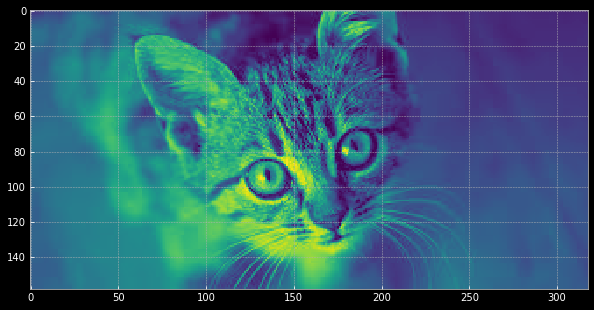

In [383]:
img_dir = 'Cat_Dog_data/'
#pic= index.jpeg
img = cv2.imread(img_dir+'index.jpeg',0)
plt.gca().imshow(img) 

In [386]:
predict_transfer(path)

0

Whaou! It's work. It predict cat

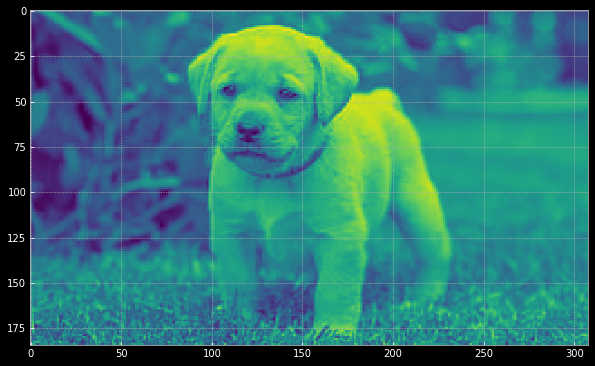

In [387]:
img_dir = 'Cat_Dog_data/'
#pic= index.jpeg
img = cv2.imread(img_dir+'Im2.jpg',0)
plt.gca().imshow(img) 

In [388]:
predict_transfer(path)

1

It's predict also a dog!

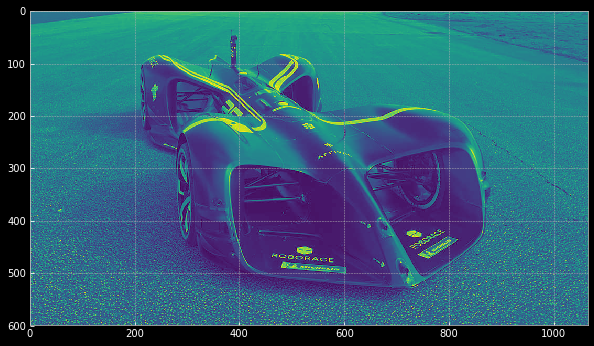

In [389]:
img_dir = 'Cat_Dog_data/'
#pic= index.jpeg
img = cv2.imread(img_dir+'car.jpg',0)
plt.gca().imshow(img) 

In [390]:
predict_transfer(path)

1

## As we cn see, the model is able to predict, but it's not predict well and the accuracy is low. So we have to improve our model. 

# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

In [394]:
# plt.bar(('NN image', 'CNN image',
#          'CNN scrambled', 'NN scrambled'),
#         accuracy_list, width=0.4)
# plt.ylim((min(accuracy_list)-5, 53))
# plt.ylabel('Accuracy [%]')
# for tick in plt.gca().xaxis.get_major_ticks():
#     tick.label.set_fontsize(20)
# plt.title('Performance comparison');

### Checking Model Parameters

In [395]:
print(dir(model_cnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_tracing_name', '_version', 'add_module', 'apply', 'buffers', 'children', 'conv1', 'conv2', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc1', 'fc2', 'float', 'forward', 'half', 'load_state_dict', 'modules', 'n_feature', 'named_buffers', 'named_children', 'named_modules

In [396]:
print(dir(model_fnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_tracing_name', '_version', 'add_module', 'apply', 'buffers', 'children', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'half', 'input_size', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'network